According to Kim Yoon's paper: https://arxiv.org/abs/1408.5882, sentence classification (including sentiment analysis) can be done using CNN. This notebook I will try to take it into practice.

## Install some packages

In [34]:
import numpy as np
import keras
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import sequence
from keras import Sequential, Input, Model
from keras.layers import Dense, Activation, Dropout, Embedding, Conv1D, GlobalMaxPool1D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report,f1_score
import pandas as pd
import seaborn as sns

import os

## Take a sneak peek at the data
I first planned to crawl data from autohome.com but it has very strong anti-spider technique. To save time and try to evaluate if it works, I crawled around 199k comments from 58che.com to see if the CNN method works. 

In [24]:
DS_PATH = 'data/'
LABELS = {0:'neg',1:'pos'}

x = []
y = []

with open(os.path.join(DS_PATH, 'comment.txt'),'r',encoding='utf-8') as f:
    for line in f:
        row = line.split(' ', 1)
        x.append(row[1].strip())
        y.append(row[0])

y = [1 if _=='v1' else 0 for _ in y]

print('Length of data set: {}'.format(len(x)))
print('First few lines of x:')
print(x[:10])
print('First few lines of y:')
print(y[:10])

Length of data set: 189139
First few lines of x:
['不过就是起步慢一点。', '一箱油才跑400多，严重怀疑行车电脑油耗的准确性', '前中央扶手储存空间太小,只能开车垫胳膊用.', '先介绍一下我的车，骐达手动最最最最低配。月光银，4000公里以前基本油耗是5.7-5.9没有超过6.0，不过4000公里以后感觉发动机明显声音变大，油耗也有点升高达到6.0 所以近期也比较着急拉车赶紧做二保。', '我跑过180KM有点飘', '再有一个就是风声大了点', '空调坏过一次', '空调我坐后面就比较吃亏了，开到3档前面喊冷，我刚感觉到不热，比较麻烦！', '我的DD是08年6月的，现在跑了3W6。今天上班的时候挂D档起步，听到右侧前轮有轻微的“吱吱”声，下车查看无果。继续开车前进，“吱吱”声依然，踩刹车时“吱吱”声就变的很大了，松开刹车，声响随着车子前进和提速慢慢变小。再踩一脚刹车“吱吱”声又出现了。不', '车内异响。有时在波棍座附近、有时在车顶灯附近、有时在左驾驶员车窗上方...确实有时很烦人，']
First few lines of y:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Preprocessing
We will try preprocessing Chinese text in 2 ways
1. Without word split
2. With word split (like using jieba package)

In this post I will explore the method without word split.
We use keras Tokenizer to turn word(charactor) into index

In [25]:
tokenizer = Tokenizer(char_level=True, oov_token='UNK')
tokenizer.fit_on_texts(x)
DICTLEN = len(tokenizer.word_index)
print('Length of dictionary:')
print(DICTLEN)
keys = [_[0] for _ in tokenizer.word_index.items()]
values = [_[1] for _ in tokenizer.word_index.items()]
print('First few items in dictionary:')
print({k: v for k, v in zip(keys[:10],values[:10])})

Length of dictionary:
4485
First few items in dictionary:
{'，': 1, '的': 2, '。': 3, '不': 4, '车': 5, '是': 6, '有': 7, '了': 8, '0': 9, ' ': 10}


In [26]:
x_seq = tokenizer.texts_to_sequences(x)
print('First example after preprocessing:')
print(x_seq[0])

First example after preprocessing:
[4, 51, 29, 6, 79, 191, 299, 11, 32, 3]


In [27]:
x_seq[4:7]

[[22, 161, 51, 17, 92, 9, 352, 193, 7, 32, 692],
 [272, 7, 11, 27, 29, 6, 236, 83, 14, 8, 32],
 [33, 121, 621, 51, 11, 144]]

### Padding sequence
In order to train CNN easier, I make comments into same length. To do so, I use the pad_sequence function in Keras.

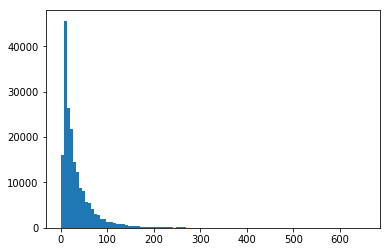

In [6]:
plt.hist(x=[len(_) for _ in x_seq], bins=100);

Let's set maxlen as 50 to be our first choice.

In [28]:
MAXLEN = 100
x_idx = sequence.pad_sequences(x_seq, maxlen=MAXLEN, padding='post', value=0)
#x_idx = x_idx.tolist()

## Split the data into train set and val set

In [29]:
np.random.seed(1)
index = list(range(len(x)))
np.random.shuffle(index)

# set training length as 95%
TRAINLEN = round(len(x)*0.95)
train_index = index[:TRAINLEN]
val_index = index[TRAINLEN:]

In [30]:
x_train_raw = [x[i] for i in train_index]
x_val_raw = [x[i] for i in val_index]

x_train = [x_idx[i] for i in train_index]
y_train = [y[i] for i in train_index]
x_val = [x_idx[i] for i in val_index]
y_val = [y[i] for i in val_index]

In [31]:
print('Positive count for whole data set:')
print('{} ({})'.format(sum(y), sum(y)/len(y)))
print('Positive count for training set:')
print('{} ({})'.format(sum(y_train), sum(y_train)/len(y_train)))
print('Positive count for validation set:')
print('{} ({})'.format(sum(y_val), sum(y_val)/len(y_val)))

Positive count for whole data set:
112515 (0.5948799560111876)
Positive count for training set:
106915 (0.5950234302823878)
Positive count for validation set:
5600 (0.5921539600296077)


In [11]:
x_train_raw[5]

'我喜欢宝马的前脸，尊贵时尚且不失霸气。'

In [12]:
x_train[5]

array([  22,  156,  228,  495,  332,    2,   73,  555,    1, 1359,  469,
         19,  244,  280,    4,  510,  637,   89,    3,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [13]:
y_train[5]

1

In [14]:
x_val_raw[1]

'油耗:让人惊喜'

In [15]:
x_val[1]

array([ 15,  54,  16, 185,  46, 391, 156,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [16]:
y_val[1]

1

### Train CNN model
Set up some basic hyper parameters first. Based on CPU or GPU:

In [17]:
if tf.test.is_gpu_available():
    BATCH_SIZE = 128
    EPOCHS = 8

else:
    BATCH_SIZE = 64
    EPOCHS = 8

In [18]:
EMBED_DIM = 40
FILTERS = 128
KERNEL_SIZE = 3
HIDDEN_UNITS = 128
VOCAB_SIZE = len(tokenizer.word_index)+1

#### 1. without drop out layer

In [44]:
model1 = Sequential()

# Start off with embedding layer to map vocab ids into EMBED_DIM dimensions
model1.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN))
#model.add(Dropout(0.2))

# Add CNN
model1.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'))

# Add Max Pooling
model1.add(GlobalMaxPool1D())

# Add an MLP
model1.add(Dense(HIDDEN_UNITS))
#model.add(Dropout(0.2))
model1.add(Activation('relu'))

# Project into single unit output layer, and convert with sigmoid
model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 40)            179440    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 128)           15488     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total para

In [21]:
earlystopping = EarlyStopping(monitor='val_loss',patience=2,verbose=1,mode='min')
checkpoint = ModelCheckpoint('model/model1_epoch.h5',verbose=1,monitor='val_loss',mode='min',save_best_only=True)

model1.fit(np.array(x_train), np.array(y_train), 
          batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_split=0.1,
          callbacks=[checkpoint,earlystopping])

Train on 161713 samples, validate on 17969 samples
Epoch 1/8
161713/161713 [==============================] - 69s 427us/step - loss: 0.2741 - acc: 0.8852 - val_loss: 0.2584 - val_acc: 0.8932

Epoch 00001: val_loss improved from inf to 0.25837, saving model to model/model1_epoch01.h5
Epoch 2/8
161713/161713 [==============================] - 68s 420us/step - loss: 0.2124 - acc: 0.9172 - val_loss: 0.2434 - val_acc: 0.9026

Epoch 00002: val_loss improved from 0.25837 to 0.24344, saving model to model/model1_epoch02.h5
Epoch 3/8
161713/161713 [==============================] - 69s 427us/step - loss: 0.1849 - acc: 0.9291 - val_loss: 0.2337 - val_acc: 0.9085

Epoch 00003: val_loss improved from 0.24344 to 0.23367, saving model to model/model1_epoch03.h5
Epoch 4/8
161713/161713 [==============================] - 76s 469us/step - loss: 0.1619 - acc: 0.9389 - val_loss: 0.2373 - val_acc: 0.9076

Epoch 00004: val_loss did not improve from 0.23367
Epoch 5/8
161713/161713 [=========================

In [27]:
del model1
model1 = load_model('model/model1.h5')

score, acc = model1.evaluate(np.array(x_val), np.array(y_val), batch_size=BATCH_SIZE)
print('Accuracy:')
print(acc)

9457/9457 [==============================] - 1s 84us/step
Accuracy:
0.9140319339604058


Evaluation on validation set:

In [28]:
pred = model1.predict_classes(np.array(x_val))
report = classification_report(y_pred=pred, y_true=np.array(y_val), target_names=list(LABELS.values()))
print(report)

             precision    recall  f1-score   support

        neg       0.88      0.91      0.90      3857
        pos       0.93      0.92      0.93      5600

avg / total       0.91      0.91      0.91      9457



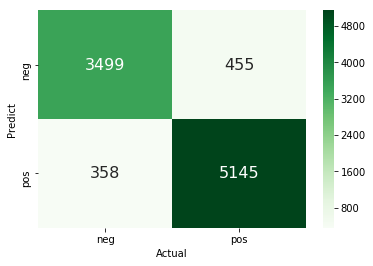

In [29]:
import pandas as pd
import seaborn as sns

predlist = [_[0] for _ in pred]
df = pd.DataFrame(data={'Predict':predlist,
                       'Actual': y_val})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

Can we reduce class imbalance effect?

In [105]:
del model1

model1 = Sequential()

# Start off with embedding layer to map vocab ids into EMBED_DIM dimensions
model1.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN))
#model.add(Dropout(0.2))

# Add CNN
model1.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'))

# Add Max Pooling
model1.add(GlobalMaxPool1D())

# Add an MLP
model1.add(Dense(HIDDEN_UNITS))
#model.add(Dropout(0.2))
model1.add(Activation('relu'))

# Project into single unit output layer, and convert with sigmoid
model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 40)           179440    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 99, 50)            4050      
_________________________________________________________________
global_max_pooling1d_25 (Glo (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               6528      
_________________________________________________________________
activation_17 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_18 (Activation)   (None, 1)                 0         
Total para

In [124]:
from sklearn.utils import class_weight

classweight = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
classweight = {cls: weight for cls, weight in enumerate(classweight)}

In [126]:
earlystopping = EarlyStopping(monitor='val_loss',patience=2,verbose=1,mode='min')
checkpoint = ModelCheckpoint('model/model1_classweight.h5',verbose=1,monitor='val_loss',mode='min',save_best_only=True)

model1.fit(np.array(x_train), np.array(y_train), 
          batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_split=0.1,
          class_weight = classweight,
          shuffle = True,
          callbacks=[checkpoint,earlystopping])

Train on 161713 samples, validate on 17969 samples
Epoch 1/8
161713/161713 [==============================] - 60s 373us/step - loss: 0.1487 - acc: 0.9446 - val_loss: 0.2539 - val_acc: 0.9083

Epoch 00001: val_loss improved from inf to 0.25388, saving model to model/model1_classweight.h5
Epoch 2/8
161713/161713 [==============================] - 60s 370us/step - loss: 0.1384 - acc: 0.9489 - val_loss: 0.2655 - val_acc: 0.9077

Epoch 00002: val_loss did not improve from 0.25388
Epoch 3/8
161713/161713 [==============================] - 57s 354us/step - loss: 0.1290 - acc: 0.9527 - val_loss: 0.2829 - val_acc: 0.9057

Epoch 00003: val_loss did not improve from 0.25388
Epoch 00003: early stopping


In [127]:
del model1
model1 = load_model('model/model1_classweight.h5')

score, acc = model1.evaluate(np.array(x_val), np.array(y_val), batch_size=BATCH_SIZE)
print('Accuracy:')
print(acc)

9457/9457 [==============================] - 1s 93us/step
Accuracy:
0.9136089667956774


In [128]:
pred = model1.predict_classes(np.array(x_val))
report = classification_report(y_pred=pred, y_true=np.array(y_val), target_names=list(LABELS.values()))
print(report)

             precision    recall  f1-score   support

        neg       0.88      0.91      0.90      3857
        pos       0.94      0.91      0.93      5600

avg / total       0.91      0.91      0.91      9457



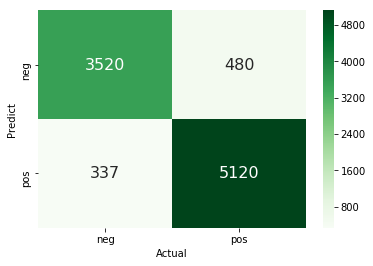

In [129]:
import pandas as pd
import seaborn as sns

predlist = [_[0] for _ in pred]
df = pd.DataFrame(data={'Predict':predlist,
                       'Actual': y_val})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

How about I make class_weight more skew?

#### 2. with drop out layer

In [73]:
model2 = Sequential()

# Start off with embedding layer to map vocab ids into EMBED_DIM dimensions
model2.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN))
model2.add(Dropout(0.2))

# Add CNN
model2.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'))

# Add Max Pooling
model2.add(GlobalMaxPool1D())

# Add an MLP
model2.add(Dense(HIDDEN_UNITS))
model2.add(Dropout(0.2))
model2.add(Activation('relu'))

# Project into single unit output layer, and convert with sigmoid
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 40)           179440    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 40)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 98, 128)           15488     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_13 (Activation)   (None, 128)               0         
__________

In [74]:
earlystopping = EarlyStopping(monitor='val_loss',mode='min',patience=2)
checkpoint = ModelCheckpoint('model/model2.h5', monitor='val_loss', mode='min')
model2.fit(np.array(x_train), np.array(y_train), 
          batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_split=0.1,
          callbacks=[earlystopping,checkpoint])

Train on 161713 samples, validate on 17969 samples
Epoch 1/8
161713/161713 [==============================] - 152s 939us/step - loss: 0.2738 - acc: 0.8860 - val_loss: 0.2349 - val_acc: 0.9091
Epoch 2/8
161713/161713 [==============================] - 154s 949us/step - loss: 0.2156 - acc: 0.9162 - val_loss: 0.2195 - val_acc: 0.9139
Epoch 3/8
161713/161713 [==============================] - 156s 963us/step - loss: 0.1972 - acc: 0.9242 - val_loss: 0.2187 - val_acc: 0.9162
Epoch 4/8
161713/161713 [==============================] - 154s 950us/step - loss: 0.1848 - acc: 0.9295 - val_loss: 0.2112 - val_acc: 0.9176
Epoch 5/8
161713/161713 [==============================] - 155s 958us/step - loss: 0.1742 - acc: 0.9343 - val_loss: 0.2113 - val_acc: 0.9182
Epoch 6/8
161713/161713 [==============================] - 161s 995us/step - loss: 0.1675 - acc: 0.9370 - val_loss: 0.2146 - val_acc: 0.9187


From above it seems like we can set EPOCHS larger because val_loss is still decreasing.

In [75]:
del model2
model2 = load_model('model/model2.h5')
score, acc = model2.evaluate(np.array(x_val), np.array(y_val), batch_size=BATCH_SIZE)
print('Accuracy:')
print(acc)

9457/9457 [==============================] - 2s 196us/step
Accuracy:
0.9230199853474158


Evaluation on validation set:

In [77]:
from sklearn.metrics import classification_report, f1_score

pred = model2.predict_classes(np.array(x_val))
report = classification_report(y_pred=pred, y_true=np.array(y_val), target_names=list(LABELS.values()))
print(report)
f1_macro = f1_score(y_val, pred, average='macro')
print('F1 score (macro): {}'.format(f1_macro))

             precision    recall  f1-score   support

        neg       0.90      0.92      0.91      3857
        pos       0.94      0.93      0.93      5600

avg / total       0.92      0.92      0.92      9457

F1 score (macro): 0.9205513850403366


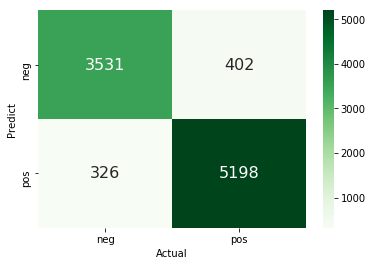

In [78]:
import pandas as pd
import seaborn as sns

predlist = [_[0] for _ in pred]
df = pd.DataFrame(data={'Predict':predlist,
                       'Actual': y_val})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

#### 3. Changing filter kernal size from 3 to 2

In [79]:
KERNEL_SIZE = 2

In [80]:
model3 = Sequential()

# Start off with embedding layer to map vocab ids into EMBED_DIM dimensions
model3.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN))
model3.add(Dropout(0.2))

# Add CNN
model3.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'))

# Add Max Pooling
model3.add(GlobalMaxPool1D())

# Add an MLP
model3.add(Dense(HIDDEN_UNITS))
model3.add(Dropout(0.2))
model3.add(Activation('relu'))

# Project into single unit output layer, and convert with sigmoid
model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 40)           179440    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 40)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 99, 128)           10368     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_15 (Activation)   (None, 128)               0         
__________

In [81]:
earlystopping = EarlyStopping(monitor='val_loss',verbose=1, mode='min',patience=2)
checkpoint = ModelCheckpoint('model3.h5',monitor='val_loss',verbose=1,mode='min',save_best_only=True)
model3.fit(np.array(x_train), np.array(y_train), 
          batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_split=0.1,
          callbacks=[earlystopping,checkpoint])

Train on 161713 samples, validate on 17969 samples
Epoch 1/8
161713/161713 [==============================] - 145s 900us/step - loss: 0.2843 - acc: 0.8805 - val_loss: 0.2432 - val_acc: 0.9021

Epoch 00001: val_loss improved from inf to 0.24316, saving model to model3.h5
Epoch 2/8
161713/161713 [==============================] - 144s 888us/step - loss: 0.2266 - acc: 0.9108 - val_loss: 0.2332 - val_acc: 0.9081

Epoch 00002: val_loss improved from 0.24316 to 0.23321, saving model to model3.h5
Epoch 3/8
161713/161713 [==============================] - 143s 885us/step - loss: 0.2092 - acc: 0.9184 - val_loss: 0.2276 - val_acc: 0.9121

Epoch 00003: val_loss improved from 0.23321 to 0.22758, saving model to model3.h5
Epoch 4/8
161713/161713 [==============================] - 143s 882us/step - loss: 0.1970 - acc: 0.9239 - val_loss: 0.2229 - val_acc: 0.9137

Epoch 00004: val_loss improved from 0.22758 to 0.22287, saving model to model3.h5
Epoch 5/8
161713/161713 [==============================] 

In [82]:
score, acc = model3.evaluate(np.array(x_val), np.array(y_val), batch_size=BATCH_SIZE)
print('Accuracy:')
print(acc)

9457/9457 [==============================] - 1s 112us/step
Accuracy:
0.9178386379891676


In [84]:
pred = model3.predict_classes(np.array(x_val))
report = classification_report(y_pred=pred, y_true=np.array(y_val), target_names=list(LABELS.values()))
print(report)
f1_macro = f1_score(y_val, pred, average='macro')
print('F1 score (macro): {}'.format(f1_macro))

             precision    recall  f1-score   support

        neg       0.89      0.91      0.90      3857
        pos       0.94      0.92      0.93      5600

avg / total       0.92      0.92      0.92      9457

F1 score (macro): 0.9153357918916291


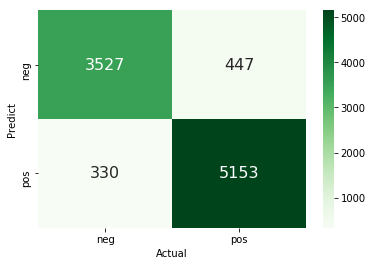

In [85]:
predlist = [_[0] for _ in pred]
df = pd.DataFrame(data={'Predict':predlist,
                       'Actual': y_val})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

Try different kernel sizes in one model

In [95]:
EMBED_DIM = 40
FILTERS = 50
KERNEL_SIZE1 = 2
KERNEL_SIZE2 = 3
KERNEL_SIZE3 = 4
KERNEL_SIZE4 = 5

input_seq = Input(shape=(MAXLEN,),dtype='int32',name='input')
embed = Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN, name='embedding')(input_seq)
cnn_1 = Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE1, activation='relu', name='cnn1')(embed)
cnn_2 = Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE2, activation='relu', name='cnn2')(embed)
cnn_3 = Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE3, activation='relu', name='cnn3')(embed)
cnn_4 = Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE4, activation='relu', name='cn43')(embed)
pool1 = GlobalMaxPool1D()(cnn_1)
pool2 = GlobalMaxPool1D()(cnn_2)
pool3 = GlobalMaxPool1D()(cnn_3)
pool4 = GlobalMaxPool1D()(cnn_4)
merged = concatenate([pool1, pool2, pool3, pool4],axis=-1)
dense1 = Dense(FILTERS*4, activation='relu')(merged)
prediction = Dense(1, activation='sigmoid')(dense1)

model4 = Model(inputs=input_seq, outputs=prediction)
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 100)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 40)      179440      input[0][0]                      
__________________________________________________________________________________________________
cnn1 (Conv1D)                   (None, 99, 50)       4050        embedding[0][0]                  
__________________________________________________________________________________________________
cnn2 (Conv1D)                   (None, 98, 50)       6050        embedding[0][0]                  
__________________________________________________________________________________________________
cnn3 (Conv

In [96]:
earlystopping = EarlyStopping(monitor='val_loss',verbose=1, patience=2, mode='min')
checkpoint = ModelCheckpoint('model/model4.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
model4.fit(np.array(x_train), np.array(y_train),
           batch_size=BATCH_SIZE, 
           epochs=EPOCHS, 
           shuffle=True, 
           validation_split=0.1,
           callbacks=[checkpoint,earlystopping])

Train on 161713 samples, validate on 17969 samples
Epoch 1/8
161713/161713 [==============================] - 231s 1ms/step - loss: 0.2513 - acc: 0.8974 - val_loss: 0.2203 - val_acc: 0.9144

Epoch 00001: val_loss improved from inf to 0.22030, saving model to model/model4.h5
Epoch 2/8
161713/161713 [==============================] - 234s 1ms/step - loss: 0.1882 - acc: 0.9287 - val_loss: 0.2081 - val_acc: 0.9194

Epoch 00002: val_loss improved from 0.22030 to 0.20814, saving model to model/model4.h5
Epoch 3/8
161713/161713 [==============================] - 246s 2ms/step - loss: 0.1590 - acc: 0.9409 - val_loss: 0.2125 - val_acc: 0.9201

Epoch 00003: val_loss did not improve from 0.20814
Epoch 4/8
161713/161713 [==============================] - 226s 1ms/step - loss: 0.1348 - acc: 0.9513 - val_loss: 0.2160 - val_acc: 0.9189

Epoch 00004: val_loss did not improve from 0.20814
Epoch 00004: early stopping


In [32]:
#del model4
model4 = load_model('model/model4.h5')
score, acc = model4.evaluate(np.array(x_val), np.array(y_val), batch_size=BATCH_SIZE)
print('Accuracy:')
print(acc)

9457/9457 [==============================] - 3s 281us/step
Accuracy:
0.9246061120260666


In [35]:
pred = model4.predict(np.array(x_val))
pred = np.array([1 if result[0]>.5 else 0 for result in pred])

report = classification_report(y_pred=pred, y_true=np.array(y_val), target_names=list(LABELS.values()))
print(report)
f1_macro = f1_score(y_val, pred, average='macro')
print('F1 score (macro): {}'.format(f1_macro))

             precision    recall  f1-score   support

        neg       0.90      0.92      0.91      3857
        pos       0.94      0.93      0.94      5600

avg / total       0.92      0.92      0.92      9457

F1 score (macro): 0.922185380996825


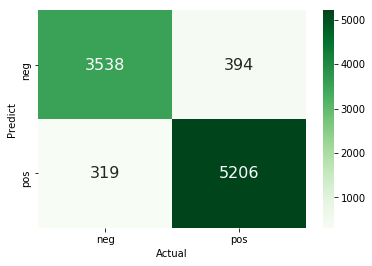

In [36]:
df = pd.DataFrame(data={'Predict':pred,
                       'Actual': y_val})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

### Check error
We choose the best performing model and look at the wrong predictions and dig out what to do next.

In [160]:
best_model = model4
pred = best_model.predict(np.array(x_val))
pred = np.array([1 if result[0]>.5 else 0 for result in pred])

df = pd.DataFrame(data={'Predict':pred,
                       'Actual': y_val})
error_index = df[df['Predict']!=df['Actual']].index

In [161]:
text = [x_val_raw[i] for i in error_index]
actual = ['neg' if y_val[i]==0 else 'pos' for i in error_index]
predict = ['neg' if pred[i]==0 else 'pos' for i in error_index]

error_df = pd.DataFrame(data={'comment':text, 'actual':actual, 'predict':predict})
error_df

,comment,actual,predict
0,下次便宜点,neg,pos
1,永远不知足，就是没有5，7的。3，6的还不错，在城市使用已经足够了，超车什么的很利落，想撒撒...,neg,pos
2,操控:刹车一般,pos,neg
3,尾部不若全新迈腾漂亮,neg,pos
4,".空调也用到了,不是很强劲,但今天28度左右,不觉得空调很冷,风开2挡,制冷中间位.",neg,pos
5,离地间隙偏低，基本上应该到190比较合适。,neg,pos
6,但是，对于新天籁夸张的大嘴唇，我是至今也找不到眼前一亮的感觉。,neg,pos
7,"空间:身高: 160-170CM, 空间和很足",neg,pos
8,空调区域设计保持了皮卡本色，古朴实用，当打开空调时，风量和制冷效果超乎我们的想象，这点也是风...,neg,pos
9,车门：正常，感觉重量没有偷减，就是方式与前不同。,pos,neg


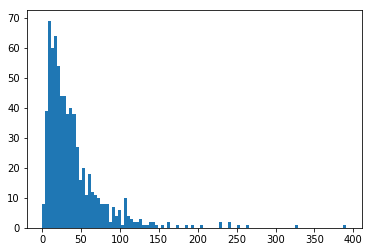

In [162]:
plt.hist(error_df.comment.str.len(), bins=100);

Proportion of text length over 50 among error comments:

In [163]:
sum(error_df.comment.str.len()>50) / len(error_df.comment)

0.24123422159887797

Proportion of text length over 50 among all comments:

In [164]:
x_seq_len_50plus = [1 if len(_)>50 else 0 for _ in x_seq]
sum(x_seq_len_50plus) / len(x_seq)

0.19998519607272958

## Use it to predict client's data

This is a simplified version since the model can only train 2 classes: positive and negative.
In practice we have more than 2 classes: in one comment a customer may have both positive or negative inputs ('pos'==1 & 'neg'==1), or just basically neutral ('pos'==0 & 'neg'==0). We'll try to fix this problem later.

Now, let's just predict comments with only positive or negative sentiments.

In [166]:
def predictnew(text):
    newtext = tokenizer.texts_to_sequences([text])
    newtext = sequence.pad_sequences(newtext, maxlen=MAXLEN, padding='post', value=0)
    prednew = best_model.predict(np.array(newtext))
    if prednew > 0.5:
        return 'pos'
    else:
        return 'neg'

In [167]:
predictnew('因为这个车的性能好 看重的是这一点')

'pos'

In [168]:
predictnew('安全系数高 空间充裕')

'pos'

In [169]:
predictnew('自己的体验感觉不错 这个牌子值得信赖')

'pos'

In [170]:
predictnew('在开车过程中有顿挫感')

'neg'

In [171]:
predictnew('这个牌子又不是什么大牌子 没啥好推荐的')

'neg'

In [172]:
predictnew('赠送的导航不好用 售后电话打不通')

'neg'

It looks like the performance of our model is not bad. Let's predict in batch:

In [214]:
Xlive = []
ylive = []
with open('data/test2.txt','r',encoding='utf-8') as fo:
    for line in fo:
        row = line.split('\t',1)
        Xlive.append(row[1].strip())
        ylive.append(row[0])

Xlive[:5]

['质量好 大品牌', '服务态度友好 热情', '品牌好 车辆性能高', '车好', '物有所值']

In [235]:
Xlive_seq = tokenizer.texts_to_sequences(Xlive)
Xlive_seq = sequence.pad_sequences(Xlive_seq, maxlen=MAXLEN, padding='post', value=0)
pred_live = best_model.predict(Xlive_seq)
pred_live = [1 if pred[0] >.1 else 0 for pred in pred_live]

In [236]:
ylive = [int(x) for x in ylive]
report = classification_report(y_pred=np.array(pred_live), y_true=np.array(ylive), target_names=list(LABELS.values()))
print('Classification report: \n')
print(report)
f1_macro = f1_score(ylive, pred_live, average='macro')
print('F1 score (macro): {}'.format(f1_macro))

Classification report: 

             precision    recall  f1-score   support

        neg       0.64      0.69      0.66       207
        pos       1.00      0.99      1.00     16075

avg / total       0.99      0.99      0.99     16282

F1 score (macro): 0.829530295451987


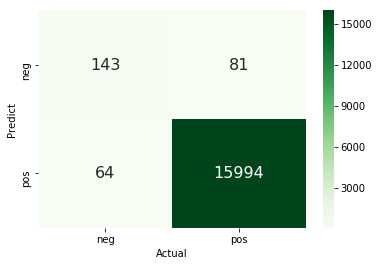

In [237]:
df = pd.DataFrame(data={'Predict':pred_live,
                       'Actual': ylive})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

Precision for the negative class is very low. It's because the data set itself is highly unbalanced

Again, let's look at what went wrong:

In [207]:
df = pd.DataFrame(data={'Predict':pred_live,
                       'Actual': ylive})
error_index = df[df['Predict']!=df['Actual']].index

text = [Xlive[i] for i in error_index]
actual = ['neg' if ylive[i]==0 else 'pos' for i in error_index]
predict = ['neg' if pred_live[i]==0 else 'pos' for i in error_index]

error_df = pd.DataFrame(data={'comment':text, 'actual':actual, 'predict':predict})
error_df

,comment,actual,predict
0,这个车还有4驱的 动力可能会更强一些,pos,neg
1,发动机和变速箱技术成熟,pos,neg
2,有优点 不足 仅推荐,pos,neg
3,价格高 一般不怎么推荐购买 但是性能好,pos,neg
4,知名度高 大家都知道,pos,neg
5,车舒适耗油,pos,neg
6,老品牌,pos,neg
7,小毛病少,pos,neg
8,车身重 稳定性高 费油,pos,neg
9,本田品牌价格偏高 但是还是值得的,pos,neg


Compare with what were predicted correctly:

In [208]:
df = pd.DataFrame(data={'Predict':pred_live,
                       'Actual': ylive})
correct_index = df[df['Predict']==df['Actual']].index

text = [Xlive[i] for i in correct_index]
actual = ['neg' if ylive[i]==0 else 'pos' for i in correct_index]
predict = ['neg' if pred_live[i]==0 else 'pos' for i in correct_index]

correct_df = pd.DataFrame(data={'comment':text, 'actual':actual, 'predict':predict})
correct_df[:20]

,comment,actual,predict
0,质量好 大品牌,pos,pos
1,服务态度友好 热情,pos,pos
2,品牌好 车辆性能高,pos,pos
3,车好,pos,pos
4,物有所值,pos,pos
5,是因为长安福特的车辆安全性能和配置在同级别当中是出色的 在高速行驶中车辆稳定性的好,pos,pos
6,省油 经济实惠,pos,pos
7,性能适合 胜价比高,pos,pos
8,驾驶性能好,pos,pos
9,开起来舒服,pos,pos


Check length of error comments:

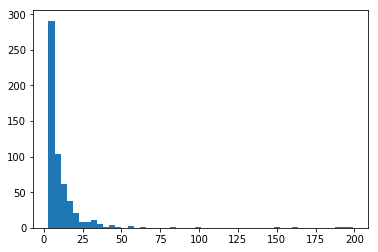

In [211]:
plt.hist(error_df.comment.str.len(), bins=50);

Check length of correct comments:

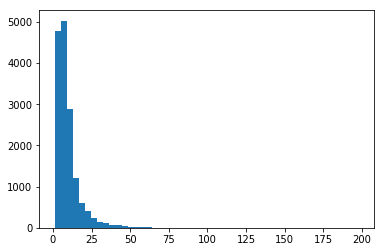

In [210]:
plt.hist(correct_df.comment.str.len(), bins=50);

In [213]:
avglen_error = np.mean(error_df.comment.str.len())
avglen_corr = np.mean(correct_df.comment.str.len())

print('Average length of error comments: {}'.format(avglen_error))
print('Average length of correct comments: {}'.format(avglen_corr))

Average length of error comments: 11.210992907801419
Average length of correct comments: 9.16541544725792


On average error comments have longer length than correct comments.

In the next posts, I'll do a word split first to see how it performs. Then I'll start using RNN and Seq2Seq models.